# Vehicle detection using cv
Detect vehicles from camera image / video using computer vision techniques and basic machine learning.  
* Template matching.
* Hog subsampling
* Color histogram
* Linear Support Vector Classifier

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time

from sklearn.externals import joblib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from VehicleFinder import *
from moviepy.editor import VideoFileClip
from lane_fitting import *
import matplotlib.gridspec as gridspec

## Load data
Train samples are in png format, which matplotlib.image read as values between (0, 1.0).  
The image is converted to YCrCb color format. According to cv2 library's [formula](http://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html), min/max values for each channel (Y, Cr, Cb) is (0, 1.0), (-0.213, 1.213), (-0.064, 1.064).

In [2]:
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')
test_image = glob.glob('./test_images/*.jpg')

print('training data size cars: {} non-cars: {}'.format(len(cars), len(notcars)))

training data size cars: 8792 non-cars: 8968


In [3]:
img = mpimg.imread(cars[10])
#img = img * 255
cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
print(np.min(cvt_img[..., 0]), np.min(cvt_img[..., 1]), np.min(cvt_img[..., 2]))
print(np.max(cvt_img[..., 0]), np.max(cvt_img[..., 1]), np.max(cvt_img[..., 2]))

0.139573 0.424467 0.45434
0.89518 0.55402 0.533411


### Visualize train data
Random samples from both classes.

In [4]:
# visualize few samples
def show_samples_path(path_list, number=10):
    rows = max(number // 5, 1)    
    plt.figure(figsize=(10, 5*rows))
    grid = gridspec.GridSpec(rows, 5)
    grid.update(wspace=.05, hspace=.05)
    show_list = random.sample(path_list, number)    
    for i in range(number):
        img = mpimg.imread(show_list[i])
        plt.subplot(grid[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

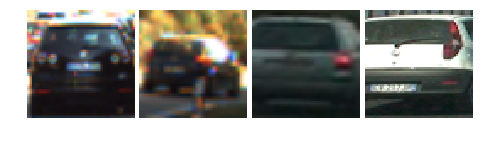

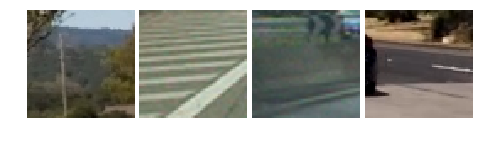

In [5]:
show_samples_path(cars, 4)
show_samples_path(notcars, 4)

## Feature extraction & training classifier
I created a pipeline class called 'VehicleFinder'. Here I use it to share parameters among processes.  
I inspect the training data and visualize features.

In [6]:
finder = VehicleFinder(color_space='YCrCb', spatial_size=(16,16), hist_nbins=32, hist_bins_range=(0,1.0), 
                       hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, channel='all', heat_thresh=4)

In [7]:
car_features = finder.feature_extraction_from_path(cars)
notcar_features = finder.feature_extraction_from_path(notcars)

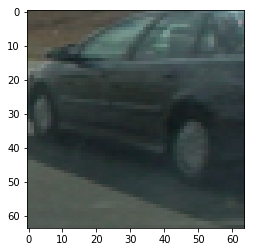

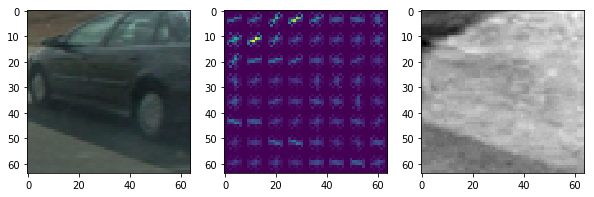

In [8]:
img = mpimg.imread(cars[1514])
plt.imshow(img)
img_cvt = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
feature, hog_img = get_hog(img_cvt[...,2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, ravel=True)
ax1.imshow(img)
ax2.imshow(hog_img)
ax3.imshow(img_cvt[..., 2], 'gray')
plt.show()

### Normalization
The graph shows normalization is required before feeding the data to LSV classifier.

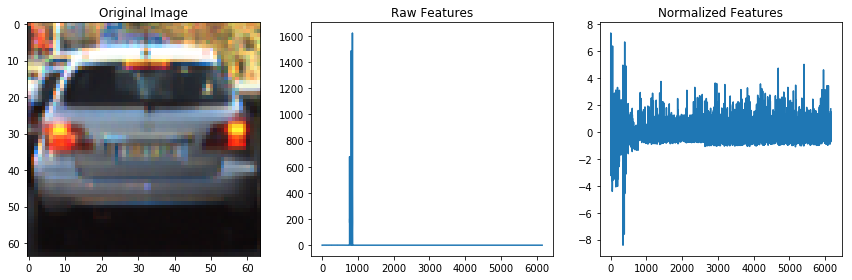

In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

### Visualize hog features
Here I visualize hog feaures of Y channel. We can see the difference between car/notcar class.

In [11]:
def visualize_hog(path_list, number):
    for i in np.random.choice(100, number, replace=False):
        img = mpimg.imread(path_list[i])
        img_cvt = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
        feature, hog_img = get_hog(img_cvt[...,0], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, ravel=False)
        ax1.imshow(img)
        ax2.imshow(hog_img)
        ax3.imshow(img_cvt[..., 0], 'gray')
        plt.show()

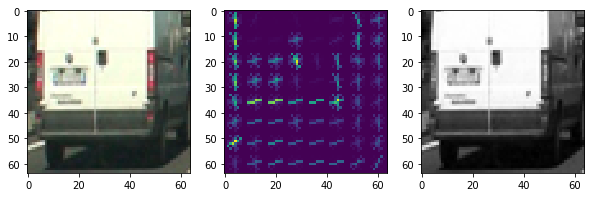

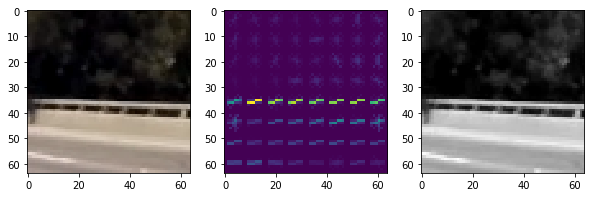

In [12]:
visualize_hog(cars, 1)
visualize_hog(notcars, 1)

### Create finder instance and train the data
I tested several parameters. The parameters that produced the best result were:  
{color_space='YCrCb', spatial_size=(16,16), hist_nbins=32, hist_bins_range=(0,1.0),  
hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, channel='all', heat_thresh=4)}  

The classifier scored accuracy of .9904.

In [13]:
finder.train_from_path(cars, notcars)
joblib.dump(finder, './finder')
joblib.dump(finder.clf, './clf')
joblib.dump(finder.scaler, './scaler')

13.46 sec to train SVC
Test accuracy of SVC: 0.9904
Predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
Truth:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00144 sec to predict 10 samples
feature vector size:  6156


['./scaler']

### or load pre-trained finder

In [4]:
# for loading pre-trained classifier
#finder = joblib.load('./finder')
finder.clf = joblib.load('./clf')
finder.scaler = joblib.load('./scaler')

### Test detector on example images
The code for the vehicle detector can be found at function 'find_cars_from_img', line 101-173 in VehicleFinder.py. It first calculates hog features on entire image then subsample them for increased efficiency.   
The result looks really good.  
The detector is not so fast though, as it runs slightly over 1 iteration per sec.  
I could make it more faster by reducing redundant features or decreasing hog search area, but I'll save it for later.  

In [14]:
%load_ext line_profiler

In [15]:
def image_test(verbose=False):
    t1 = time.time()
    for img_path in test_image:
        image = mpimg.imread(img_path)
        boxes1 = finder.find_cars_from_img(image, 400, 600, .7)        
        boxes2 = finder.find_cars_from_img(image, 380, 480, 1.1)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        #heatmap = cal_heatmap(heatmap, boxes1)
        boxes1.extend(boxes2)
        #boxes1.extend(boxes3)
        heatmap = cal_heatmap(heatmap, boxes1)
        heatmap = apply_threshold(heatmap, 0)
        label_boxes = labeled_heat_boxes(heatmap)
        
        if verbose is True:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
            ax1.imshow(draw_boxes(image, label_boxes))
            hot = ax2.imshow(heatmap, cmap='hot', clim=[0, 10])

            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(hot, cax=cax)
            plt.show()
    t2 = time.time()
    print('Prediction time for {} images: {}'.format(len(test_image), round(t2 - t1, 2)))

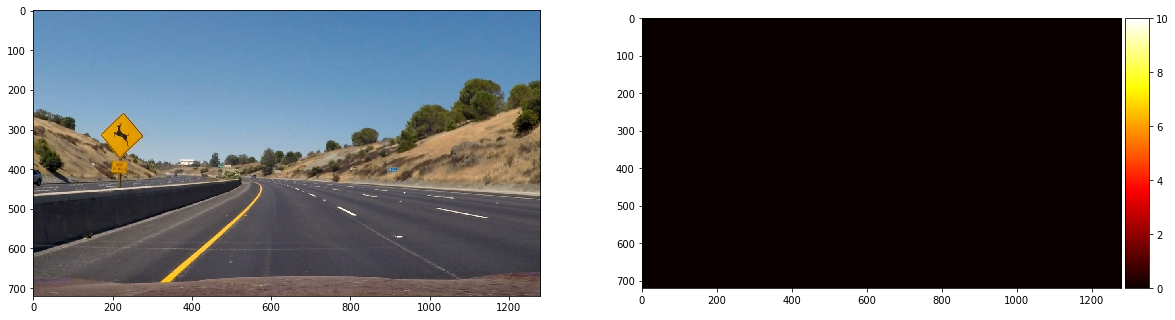

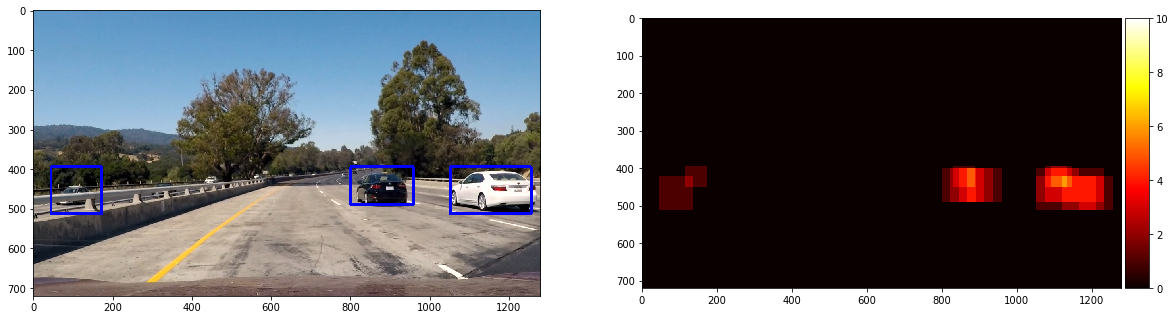

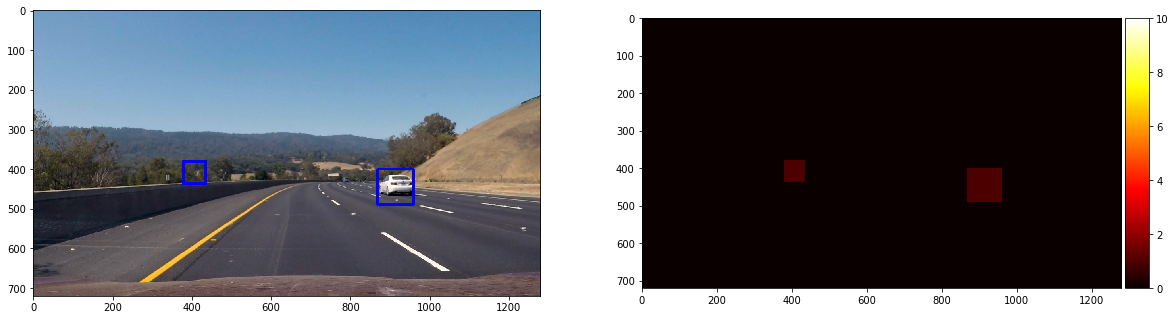

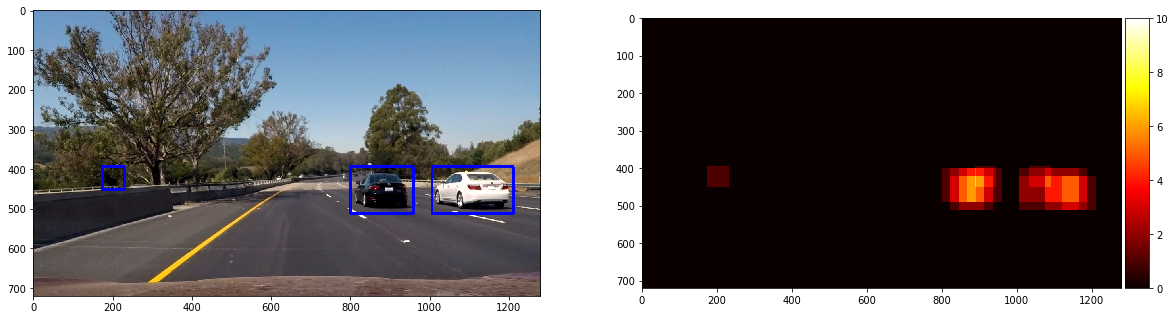

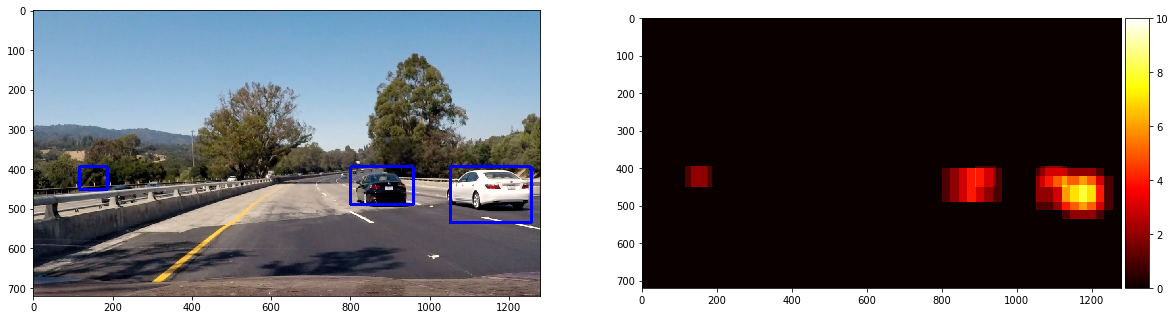

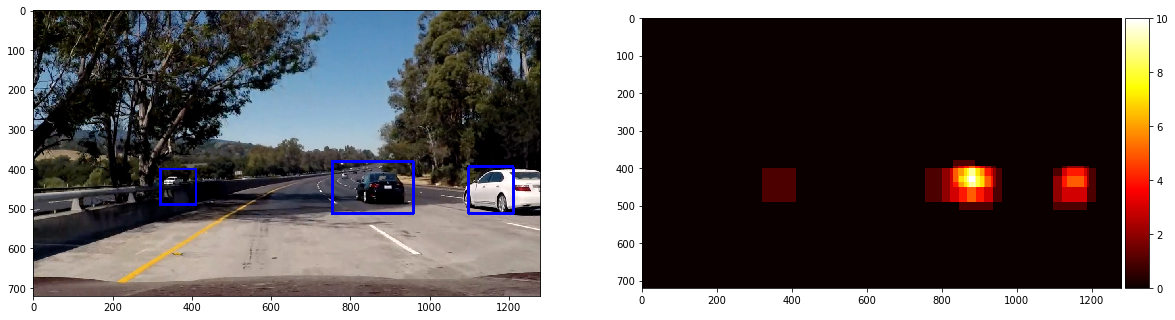

Prediction time for 6 images: 11.58


In [16]:
%lprun -f image_test image_test(verbose=True)

## Tracking with video
Added thresholded heatmap for more robustness. 

In [ ]:
param_list = [{'color_space': 'YCrCb', 
             'spatial_size': (16, 16), 
             'hist_nbins':32, 
             'hist_bins_range':(0,1.0), 
             'hog_orient':9, 
             'hog_pix_per_cell':8, 
             'hog_cell_per_block':2, 
             'channel':'all',
             'heat_thresh':4}
             ]

In [ ]:
def tester(out_path, **params):    
    finder = VehicleFinder(**params)
    finder.train_from_path(cars, notcars)
    video = './project_video.mp4'
    clip = VideoFileClip(video)
    clip_processed = clip.fl_image(finder.video_pipeline)
    clip_processed.write_videofile(out_path, fps=30, audio=False)

In [ ]:
for i, param in enumerate(param_list):
    path = './result{}.mp4'.format(i)
    tester(i, **param)

In [21]:
finder.heat_thresh = 4
video = './project_video.mp4'
#video = './test_video.mp4'
clip = VideoFileClip(video)
#finder = joblib.load('./finder')
clip_processed = clip.fl_image(finder.video_pipeline)
clip_processed.write_videofile('./result3.mp4', fps=30, audio=False)

[MoviePy] >>>> Building video ./result3.mp4
[MoviePy] Writing video ./result3.mp4


100%|█████████▉| 1512/1513 [21:05<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result3.mp4 



### With lane finding
Vehicle detector combined with lanefinding.

In [3]:
def binary_mask(gray, hls): 
    yellow = yellow_mask(hls, sensitivity=150)
    white = white_mask(hls, sensitivity=50)
    chan_mask = np.zeros_like(yellow)
    color_mask = cv2.bitwise_or(white, yellow)
    color_mask[:, :300] = 0
    color_mask[:, 1100:] = 0 
    return color_mask

In [4]:
lanefinder = continuous_pipeline(binarize_function=binary_mask, n_buffer=8)

finder = VehicleFinder(color_space='YCrCb', spatial_size=(16,16), hist_nbins=32, hist_bins_range=(0,1.0), 
                       hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, channel='all', heat_thresh=4,
                      outfunc=lanefinder.pipeline)
finder.clf = joblib.load('./clf')
finder.scaler = joblib.load('./scaler')
video = './project_video.mp4'
clip = VideoFileClip(video)
#finder = joblib.load('./finder')
clip_processed = clip.fl_image(finder.video_pipeline)
clip_processed.write_videofile('./final_result.mp4', fps=30, audio=False)

[MoviePy] >>>> Building video ./final_result.mp4
[MoviePy] Writing video ./final_result.mp4


100%|█████████▉| 1512/1513 [25:18<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./final_result.mp4 

